# Getting Started with MLRUN
----------------------------

<a id='top'></a>
### **Understanding functions and running tasks locally**

**[intall mlrun](#install)**<br>
**[mlrun setup](#setup)**<br>
**[create and run a local function](#create-local)**<br>
**[create a new mlrun Task and run it](#create-new-task)**<br>
**[inspecting the run results and outputs](#inspecting)**<br>
**[using hyperparameter tasks](#using-hyperparamter-tasks)**<br>
**[running Task's through the cli](#tasks-cli)**<br>
**[inline code and running on multiple runtimes](#inline)**<br>
**[running locally in the notebook](#run-locally)**<br>
**[hyper parameters taken from a csv file](#run-csv)**

<a id="install" ></a>
______________________________________________

# **install**

In [1]:
# Uncomment this to install mlrun package, restart the kernel after

# !pip install -U git+https//github.com/mlrun/mlrun.git@development

<a id="setup"></a>
______________________________________________

# **mlrun setup**

MLRun tracks jobs and artifacts, collecting metadata in local file directory or in a DB.

The DB/API path can be set using the environment variable ```MLRUN_DBPATH``` or the config object ```mlconf.dbpath```.

**Note:** for _distributed jobs_ and and an _interactive UI_ you must use the `mlrun-api` service (and not the file DB).

For a local file DB, in the current folder:

In [2]:
%env MLRUN_DBPATH=./

env: MLRUN_DBPATH=./


For the ```mlrun-api``` service use:

In [3]:
# %env MLRUN_DBPATH=http://mlrun-api:8080

In [4]:
from mlrun import new_function, RunTemplate, NewTask

<a id="create-local"></a>
______________________________________________

# **create and run a local code function**
The following example creates a new local function mapped to the **[training.py](training.py)** code file (located in the same folder as this notebook).

In [5]:
myfn = new_function(command='training.py')

mlrun supports multiple _**runtimes**_ (handler, local, nuclio, job, spark, mpi, etc., see **[supported runtimes](https://github.com/mlrun/mlrun/tree/master/mlrun/runtimes)** for more details). In this case, the default is a _**local**_ runtime.

<a id="create-new-task"></a>
______________________________________________

# **create a new mlrun task and submit it to our function**

An mlrun ```Task``` defines job inputs/outputs and metadata:
* input parameters
* hyper-parameters (or parameter files)
* input datasets
* default paths (for input/output)
* secrets (job credentials)
* ```Task``` metadata: name, project, labels, etc.

If a function supports multiple handlers (another term for method, function), we also need to define the specific handler. See [here]() for an example.

`Task` object have helper methods like `.with_params()`, `.with_secrets()`, `.with_input()`, `.set_label()` for conviniance.

This example shows how we can create a new task with various parameters and later use `.run()` to submit the task to our new function.<br>

First, we define where the output artifacts should be stored, and check first if it exists:

In [6]:
from os import path, makedirs

makedirs('./data', exist_ok=True)
out = './data'

Then we create a new task and set its properties using helper methods:

In [7]:
task = NewTask(name='demo', params={'p1': 5}, out_path=out).with_secrets('file', 'secrets.txt').set_label('type', 'demo')

In [8]:
# run our task using our new function
run_object = myfn.run(task)

[mlrun] 2019-12-19 21:59:02,759 starting run demo uid=9070a2c81dd84fa9bac537a0d4918cfb  -> ./
[mlrun] 2019-12-19 21:59:31,599 logging run results to: ./
Run: demo (uid=9070a2c81dd84fa9bac537a0d4918cfb)
Params: p1=5, p2=a-string
accesskey = 456
file
b"i'm a local input file"


[mlrun] 2019-12-19 21:59:31,599 logging run results to: ./
Run: demo (uid=9070a2c81dd84fa9bac537a0d4918cfb)
Params: p1=5, p2=a-string
accesskey = 456
file
b"i'm a local input file"




uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...918cfb,0,Dec 19 21:59:31,completed,demo,type=demokind=owner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-gn7c2framework=sklearn,infile.txt,p1=5p2=a-string,accuracy=10loss=15,modelhtml_resultdatasetchart.html


to track results use .show() or .logs() or in CLI: 
!mlrun get run 9070a2c81dd84fa9bac537a0d4918cfb  , !mlrun logs 9070a2c81dd84fa9bac537a0d4918cfb 
[mlrun] 2019-12-19 21:59:32,155 run executed, status=completed


<a id="inspecting"></a>
______________________________________________

# **inspecting the run results and outputs**

Every ```run``` object (the result of a `.run()` method) has the following properties and methods:
* `.uid()`   - return the unique id
* `.state()` - return the last known state
* `.show()`  - show the latest task state and data in a visual widget
* `.outputs` - return a dict of the run results and artifact paths
* `.logs()`  - return the latest logs, use `Watch=False` to disable interactive mode in running tasks
* `.artifact(key)` - return full artifact details
* `.output(key)`   - return specific result or artifact (path)
* `.to_dict()`, `.to_yaml()`, `.to_json()` - convert the run object to dict/yaml/json

In [9]:
run_object.uid()

'9070a2c81dd84fa9bac537a0d4918cfb'

In [10]:
run_object.to_dict()

{'spec': {'parameters': {'p1': 5, 'p2': 'a-string'},
  'inputs': {'infile.txt': 'infile.txt'},
  'outputs': [],
  'output_path': './data',
  'function': 'default/training:b2f63ddd1bcc34feb8f4b767f383d397ec42a6e7',
  'secret_sources': [],
  'data_stores': []},
 'metadata': {'uid': '9070a2c81dd84fa9bac537a0d4918cfb',
  'name': 'demo',
  'project': '',
  'labels': {'type': 'demo',
   'kind': '',
   'owner': 'admin',
   'host': 'jupyter-qlqrqnzi25-vogv2-79db4f79d-gn7c2',
   'framework': 'sklearn'},
  'iteration': 0},
 'status': {'state': 'completed',
  'results': {'accuracy': 10, 'loss': 15},
  'artifacts': [{'key': 'model',
    'kind': '',
    'tree': '9070a2c81dd84fa9bac537a0d4918cfb',
    'target_path': './data/model.txt',
    'hash': '8170b9a53bbb1f4d52733bc6824955e3a362d4a1',
    'size': 10},
   {'key': 'html_result',
    'kind': '',
    'tree': '9070a2c81dd84fa9bac537a0d4918cfb',
    'target_path': './data/result.html',
    'hash': '11f50bed0aa902cbdcf3249c610af88bc26f1619',
    'vie

In [11]:
run_object.state()

'completed'

In [12]:
run_object.show()

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...918cfb,0,Dec 19 21:59:31,completed,demo,type=demokind=owner=adminhost=jupyter-qlqrqnzi25-vogv2-79db4f79d-gn7c2framework=sklearn,infile.txt,p1=5p2=a-string,accuracy=10loss=15,modelhtml_resultdatasetchart.html


In [13]:
run_object.outputs

{'accuracy': 10,
 'loss': 15,
 'model': './data/model.txt',
 'html_result': './data/result.html',
 'dataset': './data/dataset.csv',
 'chart.html': './data/chart.html'}

In [14]:
run_object.logs()

[mlrun] 2019-12-19 21:59:31,599 logging run results to: ./
Run: demo (uid=9070a2c81dd84fa9bac537a0d4918cfb)
Params: p1=5, p2=a-string
accesskey = 456
file
b"i'm a local input file"




In [15]:
run_object.artifact('dataset')

{'key': 'dataset',
 'kind': 'table',
 'tree': '9070a2c81dd84fa9bac537a0d4918cfb',
 'target_path': './data/dataset.csv',
 'hash': 'c64e1ae504eb958a7a507e5d6fe43645a1bfb034',
 'viewer': 'table',
 'size': 12,
 'header': ['A', 'B', 'C']}

<a id="using-hyperparamter-tasks"></a>
______________________________________________

# **using hyper-parameter tasks**
In many cases we want to run the same function with diferent input values and select the best result.<br>

You can specify parameters with a list of values and mlrun will run all the parameter combinations as a single hyper-param task.<br>

Each unique run combination is called an _**iteration**_, where '0' iteration is the parent task.

Use `.with_hyper_params()` and provide lists or values, we use the selector string to indicate which will iteration will be selected as the winning result (indicated using [```min``` or ```max```].[```output-value```])

In [16]:
run = myfn.run(task.with_hyper_params({'p2': [5, 2, 3]}, 'min.loss'))

[mlrun] 2019-12-19 21:59:32,670 starting run demo uid=314ef6af4cfb4ec69895940b2af95dbe  -> ./
> --------------- Iteration: (1) ---------------
[mlrun] 2019-12-19 22:00:00,995 logging run results to: ./
Run: demo (uid=314ef6af4cfb4ec69895940b2af95dbe-1)
Params: p1=5, p2=5
accesskey = 456
file
b"i'm a local input file"


> --------------- Iteration: (2) ---------------
[mlrun] 2019-12-19 22:00:30,658 logging run results to: ./
Run: demo (uid=314ef6af4cfb4ec69895940b2af95dbe-2)
Params: p1=5, p2=2
accesskey = 456
file
b"i'm a local input file"


> --------------- Iteration: (3) ---------------
[mlrun] 2019-12-19 22:00:59,288 logging run results to: ./
Run: demo (uid=314ef6af4cfb4ec69895940b2af95dbe-3)
Params: p1=5, p2=3
accesskey = 456
file
b"i'm a local input file"




uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...f95dbe,0,Dec 19 21:59:32,completed,demo,type=demokind=owner=admin,,p1=5,best_iteration=1accuracy=10loss=15,modelhtml_resultdatasetchart.htmliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run 314ef6af4cfb4ec69895940b2af95dbe  , !mlrun logs 314ef6af4cfb4ec69895940b2af95dbe 
[mlrun] 2019-12-19 22:00:59,821 run executed, status=completed


In [17]:
run.outputs

{'best_iteration': 1,
 'accuracy': 10,
 'loss': 15,
 'model': './data/1/model.txt',
 'html_result': './data/1/result.html',
 'dataset': './data/1/dataset.csv',
 'chart.html': './data/1/chart.html',
 'iteration_results': './data/iteration_results.csv'}

<a id="tasks-cli"></a>
______________________________________________

# **running tasks through the cli**

In [18]:
!mlrun run --name train_hyper -x p1="[3,7,5]" -p p2=5 training.py

[mlrun] 2019-12-19 22:01:28,421 starting run train_hyper uid=dfa675cca27e44388f46b9ed16eb0874  -> ./
> --------------- Iteration: (1) ---------------
[mlrun] 2019-12-19 22:01:57,256 logging run results to: ./
Run: train_hyper (uid=dfa675cca27e44388f46b9ed16eb0874-1)
Params: p1=3, p2=5
accesskey = None
file
b"i'm a local input file"


> --------------- Iteration: (2) ---------------
[mlrun] 2019-12-19 22:02:26,342 logging run results to: ./
Run: train_hyper (uid=dfa675cca27e44388f46b9ed16eb0874-2)
Params: p1=7, p2=5
accesskey = None
file
b"i'm a local input file"


> --------------- Iteration: (3) ---------------
[mlrun] 2019-12-19 22:02:55,574 logging run results to: ./
Run: train_hyper (uid=dfa675cca27e44388f46b9ed16eb0874-3)
Params: p1=5, p2=5
accesskey = None
file
b"i'm a local input file"


[mlrun] 2019-12-19 22:02:56,057 run executed, status=completed


In [19]:
# see other CLI commands
!mlrun

Usage: mlrun [OPTIONS] COMMAND [ARGS]...

Options:
  --help  Show this message and exit.

Commands:
  build   Build a container image from code and requirements.
  clean   Clean completed or failed pods/jobs
  config  Show configuration & exit
  db      Run HTTP api/database server
  deploy  Deploy model or function
  get     List/get one or more object per kind/class.
  logs    Get or watch task logs
  run     Execute a task and inject parameters.
  watch   Read current or previous task (pod) logs.


<a id="inline"></a>
______________________________________________

# **using (inline) code and running on different runtimes**

In [20]:
from mlrun.artifacts import ChartArtifact, TableArtifact, PlotArtifact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# define a function with spec as parameter
import time
def handler(context, p1=1, p2='xx'):
    # access input metadata, values, and inputs
    print(f'Run: {context.name} (uid={context.uid})')
    print(f'Params: p1={p1}, p2={p2}')
    
    time.sleep(1)
    
    # log the run results (scalar values)
    context.log_result('accuracy', p1 * 2)
    context.log_result('loss', p1 * 3)
    
    # add a lable/tag to this run 
    context.set_label('category', 'tests')
    
    # log a simple artifact + label the artifact 
    context.log_artifact('model', body=b'abc is 123', target_path='model.txt', labels={'framework': 'xgboost'})
    
    # create a matplot figure and store as artifact 
    fig, ax = plt.subplots()
    np.random.seed(0)
    x, y = np.random.normal(size=(2, 200))
    color, size = np.random.random((2, 200))
    ax.scatter(x, y, c=color, s=500 * size, alpha=0.3)
    ax.grid(color='lightgray', alpha=0.7)
    
    context.log_artifact(PlotArtifact('myfig', body=fig))
    
    # create a dataframe artifact 
    df = pd.DataFrame([{'A':10, 'B':100}, {'A':11,'B':110}, {'A':12,'B':120}])
    context.log_artifact(TableArtifact('df', df=df, visible=True), target_path='mydf.csv')

    return 'my resp'

<a id="run-locally"></a>
______________________________________________

# **run locally in the notebook**

> --------------- Iteration: (1) ---------------
Run: handler (uid=c7ea81702ec84ad9b8f9436b05cba376-1)
Params: p1=5, p2=xx

> --------------- Iteration: (2) ---------------
Run: handler (uid=c7ea81702ec84ad9b8f9436b05cba376-2)
Params: p1=2, p2=xx

> --------------- Iteration: (3) ---------------
Run: handler (uid=c7ea81702ec84ad9b8f9436b05cba376-3)
Params: p1=3, p2=xx



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...cba376,0,Dec 19 22:03:26,completed,handler,,,,best_iteration=1accuracy=10loss=15return=my resp,modelmyfig.htmldf.csviteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run c7ea81702ec84ad9b8f9436b05cba376  , !mlrun logs c7ea81702ec84ad9b8f9436b05cba376 
[mlrun] 2019-12-19 22:03:30,633 run executed, status=completed


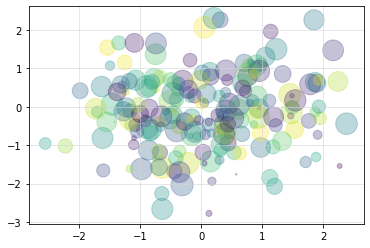

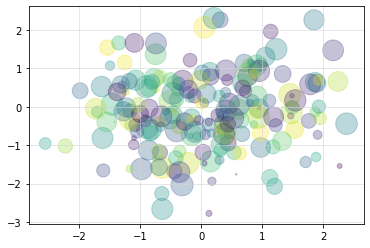

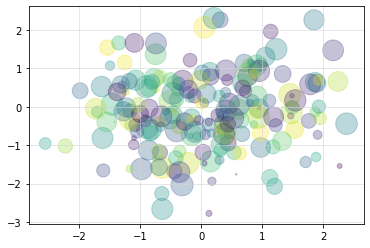

In [21]:
task = NewTask(handler=handler).with_hyper_params({'p1': [5, 2, 3]}, 'max.accuracy')
run = new_function().run(task)

<a id="run-csv"></a>
______________________________________________

# **run with hyper parameters taken from a csv file**

> --------------- Iteration: (1) ---------------
Run: handler (uid=61df382593ab4883aa8e0db950522cf2-1)
Params: p1=11, p2=33

> --------------- Iteration: (2) ---------------
Run: handler (uid=61df382593ab4883aa8e0db950522cf2-2)
Params: p1=12, p2=44

> --------------- Iteration: (3) ---------------
Run: handler (uid=61df382593ab4883aa8e0db950522cf2-3)
Params: p1=13, p2=55



uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...522cf2,0,Dec 19 22:03:31,completed,handler,,param_file.csv,,best_iteration=3accuracy=26loss=39return=my resp,modelmyfig.htmldf.csviteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run 61df382593ab4883aa8e0db950522cf2  , !mlrun logs 61df382593ab4883aa8e0db950522cf2 
[mlrun] 2019-12-19 22:03:34,506 run executed, status=completed


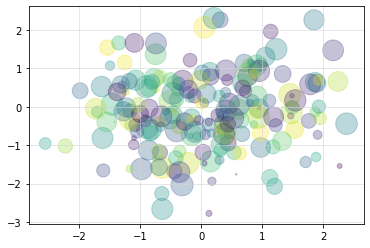

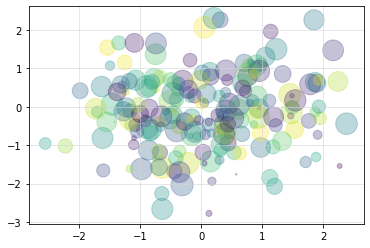

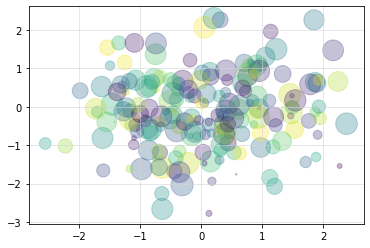

In [22]:
task = NewTask(handler=handler).with_param_file('params.csv', 'max.accuracy')
run = new_function().run(task)